In [1]:
import pandas as pd
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.8 MB/s 
     |████████████████████████████████| 16.6 MB 66 kB/s 
     |████████████████████████████████| 7.8 MB 27.3 MB/s 


Start up Google Earth Engine

In [2]:
# earthengine authenticate
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=sYaq4z8mDwD4HH5XlXwGcHgY93nWeBhLqYskisfwYiM&tc=1qghM5__IMmkAV7A2olnklpf3NgNlLipX9J2U37Ywt4&cc=_WktjVn7atTIzVMvgQm2zfCi0ye2898FPxJW1zi5blM

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfgeXvtEKt9fRm61ScAmV6vjKzpGni8C7LA7oBsQCnEsaUjoHsZOLDOTf0g

Successfully saved authorization token.


In [4]:
# # here are the GEE declarations. 
import ee
ee.Initialize()

Import basin data

In [5]:
basins = gpd.read_file('https://raw.githubusercontent.com/gee-hydro/PML.R/master/validation/PML_validation_sitelist.zip').rename(columns={'RUNOFF_MM_':'RUNOFF_MM_YR'}).to_crs('EPSG:4326')

##Get GEE Data

In [6]:
# convert each basin into a GEE polygon feature

geos = []
for i in range(len(basins)):
  geom1 = basins.to_crs('EPSG:4326').geometry.values[i]
  if geom1.geom_type == 'MultiPolygon':
    geom1 = list(geom1)[-1]
  x,y = geom1.exterior.coords.xy
  cords = np.dstack((x,y)).tolist()

  geo_obj=ee.Geometry.Polygon(cords)
  geos.append(geo_obj)

names = basins.SITE_NO.values

# set start and end dates for grabbing ET data
start='2000-10-01'
stop='2022-10-01'

<ipython-input-6-2330836a83a2>:7: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  geom1 = list(geom1)[-1]
<ipython-input-6-2330836a83a2>:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  geom1 = list(geom1)[-1]
<ipython-input-6-2330836a83a2>:7: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  geom1 = list(geom1)[-1]
<ipython-input-6-2330836a83a2>:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constitu

In [7]:
# get mean annual ET from PML-V2 

# code adapted from David Dralle
# Flux is stored as 100*mm/day, and duration between samples is 8 days
multiplier = 8.0 
PMLV2 = ee.ImageCollection("projects/pml_evapotranspiration/PML/OUTPUT/PML_V2_8day_v016");
scale = 0.01

# mapper for getting single ET raster for each timestep
def sumpml(image):
  # ET bands into one band
  temp = image.select('Es').add(image.select('Ec')).add(image.select('Ei')).multiply(scale)

  #get the first band of this new temporary image, rename it to 'ET', 
  #reproject it, and then multiply by multiplier
  temp = temp.select([0], ['ET']).reproject(
      crs='EPSG:4326',scale=1000
      ).multiply(multiplier)

  #temp should now be total ET in mm over the time window between images
  #assign the datetime stamp and the index from the original image
  temp = temp.set('system:time_start', image.get('system:time_start'))
  temp = temp.set('system:index', image.get('system:index'))
  return temp

#now, actually map the pml image collection w/ this function,
# in order to make a new combined ET image collection
PMLV2 =ee.ImageCollection(PMLV2.map(sumpml).select('ET')).filter(ee.Filter.date(start, stop)).mean().multiply(365)


In [8]:
# get mean annual ET from MODIS

modis = ee.ImageCollection('MODIS/006/MOD16A2').select('ET').filter(ee.Filter.date(start, stop)).mean().multiply(365/8)

In [ ]:
# get mean annual ET from each ET dataset for each basin

PMLV2_basin = []
MODIS_basin = []

for i,geo in enumerate(geos):
  ft = PMLV2.reduceRegion(ee.Reducer.mean(), geo, 1000)
  vals = ft.getInfo()
  PMLV2_basin.append(vals['ET'])
  ft = modis.reduceRegion(ee.Reducer.mean(), geo, 1000)
  vals = ft.getInfo()
  MODIS_basin.append(vals['ET'])

In [ ]:
basins['PMLV2'] = np.array(PMLV2_basin)
basins['PMLV2'] = basins.PMLV2
basins['MODIS'] = MODIS_basin
basins['MODIS'] = basins.MODIS/8

In [ ]:
basins.to_file('PML_MODIS_MASSBAL.shp')

In [ ]:
from google.colab import files
files.download('PML_MODIS_MASSBAL.shp')
files.download('PML_MODIS_MASSBAL.shx')
files.download('PML_MODIS_MASSBAL.prj')
files.download('PML_MODIS_MASSBAL.dbf')
files.download('PML_MODIS_MASSBAL.cpg')


##Check out results

In [13]:
from sklearn.metrics import r2_score

In [28]:
basins['PMLV2'] = basins['PMLV2'].astype('float')
basins['MODIS'] = basins['MODIS'].astype('float')
basins['MODIS_diff'] = basins.MODIS-basins.ET_EST_MM_
basins['PML_diff'] = basins.PMLV2/8-basins.ET_EST_MM_
basins = basins.dropna()

Text(0.5, 1.0, 'MODIS ET - Mass balance ET [mm]')

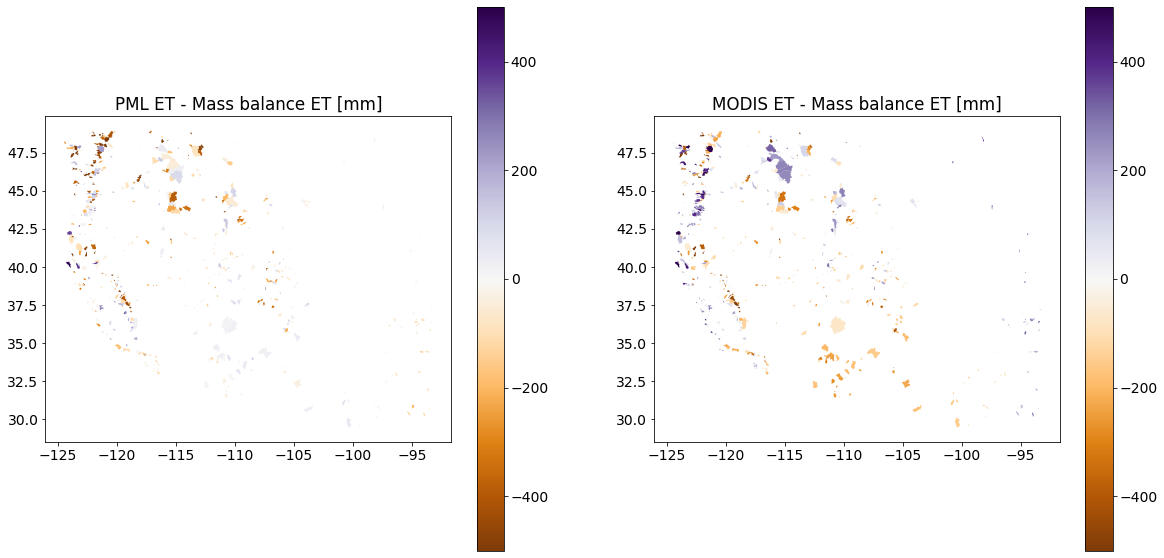

In [30]:
fig,axs = plt.subplots(1,2,figsize = (20,10))

ax = axs[0]
basins.plot(ax = ax, column = 'PML_diff', legend = True, vmin = -500, vmax = 500, cmap = 'PuOr')
ax.set_title('PML ET - Mass balance ET [mm]')


ax = axs[1]
basins.plot(ax = ax, column = 'MODIS_diff', legend = True, vmin = -500, vmax = 500, cmap = 'PuOr')
ax.set_title('MODIS ET - Mass balance ET [mm]')

-5.746250018361758 -0.5754729462817081


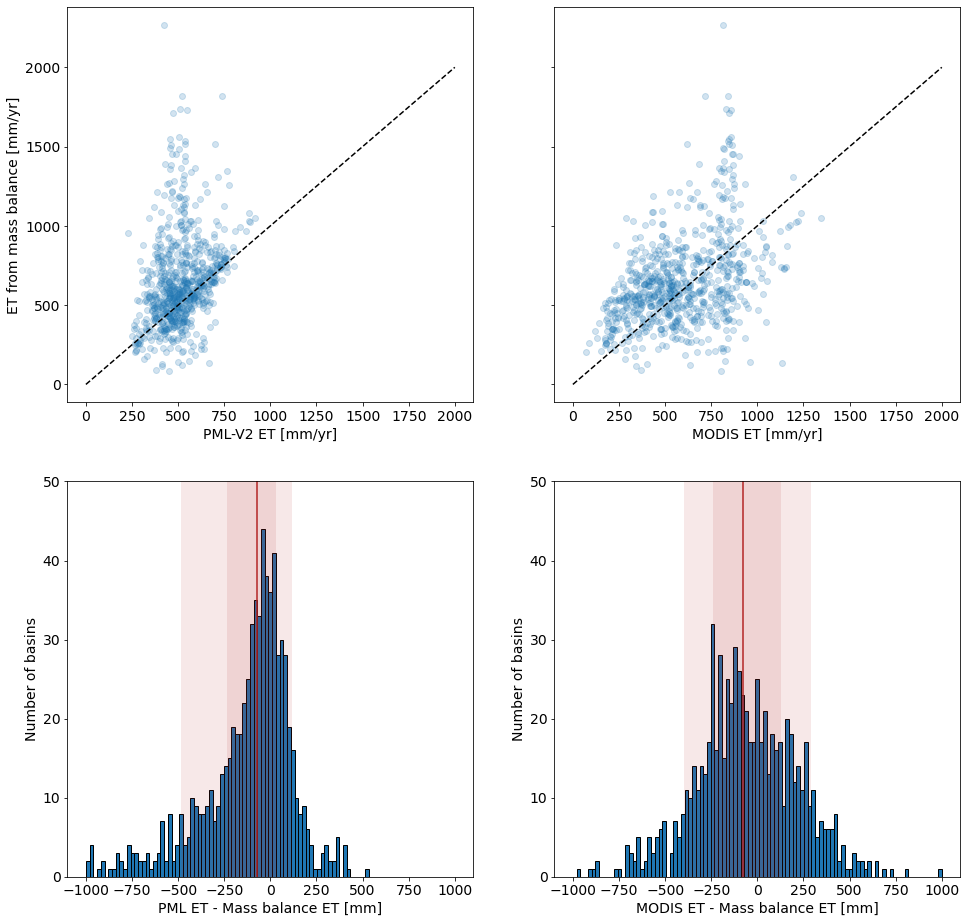

In [27]:
fig, axs = plt.subplots(2,2,figsize = (16,16))

ax = axs[0,0]
ax.scatter(basins.PMLV2/8,basins.ET_EST_MM_, alpha = 0.2)
ax.set_xlabel('PML-V2 ET [mm/yr]')
ax.set_ylabel('ET from mass balance [mm/yr]')
mask = (np.isfinite(basins.PMLV2)) & (np.isfinite(basins.ET_EST_MM_)) & (basins.PMLV2>0)
PML_R2 = r2_score(basins.PMLV2/8,basins.ET_EST_MM_)


ax = axs[0,1]
ax.scatter(basins.MODIS,basins.ET_EST_MM_, alpha=0.2)
ax.set_yticklabels([])
ax.set_xlabel('MODIS ET [mm/yr]')
MODIS_R2 = r2_score(basins.MODIS,basins.ET_EST_MM_)

for ax in [axs[0][0],axs[0][1]]:
  ax.plot([0,2000],[0,2000],c='k',ls='--')

ax = axs[1,0]
percerr_PML = (basins.PMLV2/8-basins.ET_EST_MM_)#/basins.ET_EST_MM_
ax.hist(percerr_PML,
        bins = np.linspace(-1000,1000,100), edgecolor = 'k')
ax.axvline(np.nanmedian(percerr_PML), c = 'firebrick')
ax.axvspan(np.nanpercentile(percerr_PML,25),
           np.nanpercentile(percerr_PML,75),alpha = 0.1, facecolor = 'firebrick')
ax.axvspan(np.nanpercentile(percerr_PML,10),
           np.nanpercentile(percerr_PML,90),alpha = 0.1, facecolor = 'firebrick')
ax.set_xlabel('PML ET - Mass balance ET [mm]')

ax = axs[1,1]
percerr_MODIS = (basins.MODIS-basins.ET_EST_MM_)#/basins.ET_EST_MM_
ax.hist(percerr_MODIS,
        bins = np.linspace(-1000,1000,100),edgecolor = 'k')
ax.axvline(np.nanmedian(percerr_MODIS), c = 'firebrick')
ax.axvspan(np.nanpercentile(percerr_MODIS,25),
           np.nanpercentile(percerr_MODIS,75),alpha = 0.1, facecolor = 'firebrick')
ax.axvspan(np.nanpercentile(percerr_MODIS,10),
           np.nanpercentile(percerr_MODIS,90),alpha = 0.1, facecolor = 'firebrick')
ax.set_xlabel('MODIS ET - Mass balance ET [mm]')

for ax in [axs[1,0],axs[1,1]]:
  ax.set_ylabel('Number of basins')
  ax.set_ylim(0,50)

print(PML_R2, MODIS_R2)

In [17]:
basins[basins.PMLV2.isna()]

,SITE_NO,SQMI,ABS_DIFF,STAID,LAT_GAGE,LNG_GAGE,RUNOFF_MM_YR,PPT_MM_YR,ET_EST_MM_,geometry,PMLV2,MODIS,MODIS_diff,PML_diff


In [96]:
basins[basins.SQMI<5]

,SITE_NO,SQMI,ABS_DIFF,STAID,LAT_GAGE,LNG_GAGE,RUNOFF_MM_YR,PPT_MM_YR,ET_EST_MM_,geometry
30,06301480,3.522159,0.032891,6301480,44.601355,-107.317576,75.63272,784.6580,709.02528,"POLYGON ((-895455.000 2452875.000, -895485.000..."
43,06430800,3.571502,0.042493,6430800,44.326928,-103.894371,51.83228,763.1407,711.30842,"POLYGON ((-624465.000 2396055.000, -624495.000..."
47,06614800,1.555365,0.009977,6614800,40.496094,-105.865012,108.11910,1195.3930,1087.27390,"POLYGON ((-829155.000 1983435.000, -829185.000..."
55,06746095,3.438066,0.094925,6746095,40.539982,-105.882790,55.86076,1146.9710,1091.11024,"POLYGON ((-830535.000 1987875.000, -830565.000..."
59,06821000,2.714244,0.002116,6821000,39.624719,-94.600512,256.00000,980.6243,724.62430,"POLYGON ((119445.000 1845345.000, 119445.000 1..."
...,...,...,...,...,...,...,...,...,...,...
720,14199704,0.659536,0.081207,14199704,45.205233,-122.412002,1406.05900,1613.8640,207.80500,"MULTIPOLYGON (((-2044935.000 2754855.000, -204..."
722,14206900,2.403588,0.014172,14206900,45.487896,-122.734819,746.57350,1160.6220,414.04850,"POLYGON ((-2059545.000 2789925.000, -2059575.0..."
737,14303200,3.111773,0.007046,14303200,45.324276,-123.546501,2318.00000,2933.9710,615.97100,"POLYGON ((-2127015.000 2790645.000, -2127045.0..."
745,14319830,4.159803,0.002445,14319830,43.422064,-123.039510,856.71080,2197.3620,1340.65120,"POLYGON ((-2148345.000 2574585.000, -2148375.0..."
